# Data Loading
The following are some constants that will be used to load data:

In [4]:
DATA_FOLDER = '../data/interim/experiment'
BATCH_SIZE = 16
SEED = 42

For data loading, based on the division of the data that was done in the previous notebook, a built-in torchvision dataset tool called <a href='https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder'>ImageFolder</a> will be used.
The functions to load the data will be saved in *load_dataset.py*. The definition is the following:

In [5]:
from os.path import join

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def create_train_dataloader(
        transform: transforms.Compose,
        root: str,
        batch_size: int,
        seed: int
    ) -> DataLoader:
    """Creates a dataloader for training, with an specific transform"""
    folder = join(root, "train")
    return _create_dataloader(transform, folder, batch_size, seed, True)


def create_test_dataloader(
        transform: transforms.Compose,
        root: str,
        batch_size: int,
        seed: int
    ) -> DataLoader:
    """Creates a dataloader for testing, with an specific transform"""
    folder = join(root, "test")
    return _create_dataloader(transform, folder, batch_size, seed, False)


def _create_dataloader(
        transform: transforms.Compose,
        folder:str,
        batch_size: int,
        seed: int,
        shuffle: bool
    ) -> DataLoader:
    """Creates a dataloader, with an specific transform"""
    torch.manual_seed(seed)
    data = datasets.ImageFolder(folder, transform=transform)
    return DataLoader(data, batch_size=batch_size, shuffle=shuffle)

In [35]:
# Sample transform for showing images
sample_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor()
])

The basic usage of this functions will be:

In [31]:
train_dataloader = create_train_dataloader(sample_transform, DATA_FOLDER, BATCH_SIZE, SEED)
test_dataloader = create_test_dataloader(sample_transform, DATA_FOLDER, BATCH_SIZE, SEED)

### Display a batch of images

In [32]:
from torchvision import transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

In order to test the data loaders, we will display a batch of images from each data loader. The current batch size for this test is 16, as it was define in the constant **BATCH_SIZE**.
For simplicity, a function will be created to show the images:

In [33]:
def show_sample_images(dataloader):
    #Load the first 16 images form the dataloader
    for images, labels in dataloader:
        break

    #Make a grid to display 2 rows of 8 images.
    im = make_grid(images, nrow=8)

    # Print the images
    plt.figure(figsize=(12,4))
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

* First, the train_dataloader:

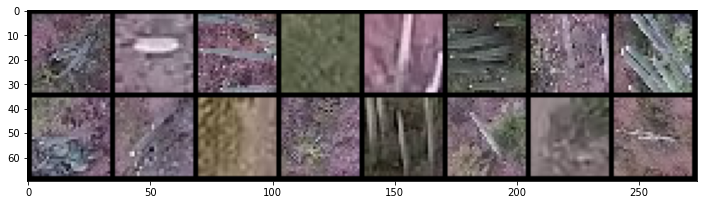

In [34]:
show_sample_images(train_dataloader)

* We continue with the test_dataloader:

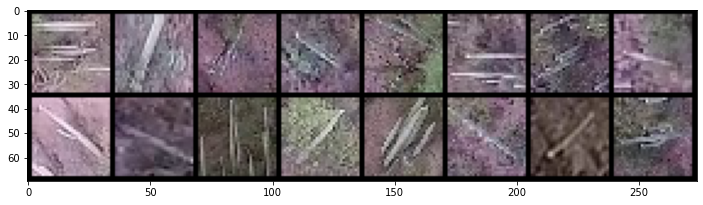

In [36]:
show_sample_images(test_dataloader)

# Transforms
In the experiment conducted by <cite >(E. López-Jiménez, et al., 2019)</cite>, two transformations were used in order to run the experiments. The purpose of these two transformations was to understand the influence of transformations in the final accuracy.
## Image Normalization vectors
For the creation of the transforms, they implemented a normalization of the images. In order to recreate the normalization of the images, it is necessary to calculate the mean and the standard deviation of the dataset. For this, we will load the images and calculate the mean and standard deviation based on the code from Willaert, J. (2021, September 24):

In [37]:
#Recreate Train Data Loader with a batch size of 64
train_dataloader = create_train_dataloader(transforms.ToTensor(), DATA_FOLDER, 64, SEED)

In [38]:
#Definition of the function provided by the article
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [39]:
#Finally, we execute the function and extract the mean and the std
mean, std = get_mean_and_std(train_dataloader)
print(f'The mean vector is the following: {mean}')
print(f'The standard deviation vector is the following: {std}')

The mean vector is the following: tensor([0.5032, 0.4517, 0.4679])
The standard deviation vector is the following: tensor([0.1513, 0.1399, 0.1533])


**Note:** The mean and the standard deviation calculated in the cell before will be used as constants in the file called *experiment_transformations.py*. The mean vector will be called MEAN_VECTOR, and the standard deviation vector will be called STD_VECTOR.

## Transforms Definition

The **"No Augmentation"** transform which will consist in: 
* Resizing the image into 32x32
* Normalization

In [41]:
no_augmentation_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean,
                        std)
])
no_augmentation_transform

Compose(
    Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=tensor([0.5032, 0.4517, 0.4679]), std=tensor([0.1513, 0.1399, 0.1533]))
)

The **"Flip Augmentation"** transform which will consist in:
* Resize into 32x32
* Random flip the image, verically or horizontally, with a probability of 0.5 of the flipping happening. Both flips are independent events.
* Normalization

In [42]:
flip_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean,
                        std)
])
flip_transform

Compose(
    Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
    RandomVerticalFlip(p=0.5)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=tensor([0.5032, 0.4517, 0.4679]), std=tensor([0.1513, 0.1399, 0.1533]))
)

## Display images with transforms
Using the transforms created before, the dataloaders will be reloaded and images will be presented in order to look at the input data for the CNN in the different experiments that will be conducted
### Display images with no_augmentation_transform
1) train_dataloader with no_aumentation_transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


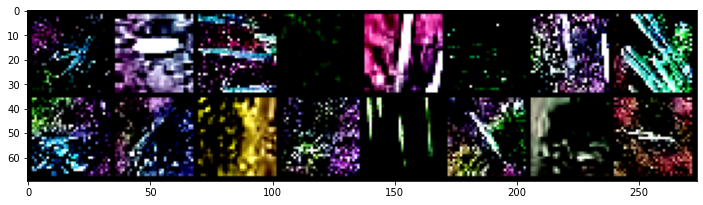

In [44]:
train_dataloader = create_train_dataloader(no_augmentation_transform, DATA_FOLDER, BATCH_SIZE, SEED)

show_sample_images(train_dataloader)

2) test_dataloader with no_aumentation_transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


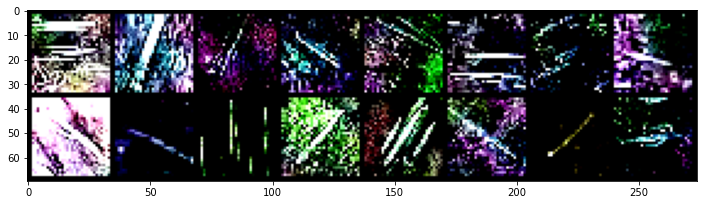

In [48]:
test_dataloader = create_test_dataloader(no_augmentation_transform, DATA_FOLDER, BATCH_SIZE, SEED)

show_sample_images(test_dataloader)

### Display images with flip_transform
1) train_dataloader with flip_transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


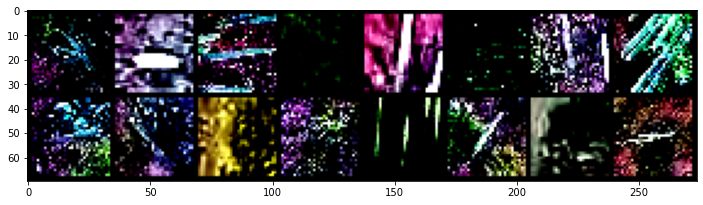

In [47]:
train_dataloader = create_train_dataloader(flip_transform, DATA_FOLDER, BATCH_SIZE, SEED)

show_sample_images(train_dataloader)

2) test_dataloader with flip_transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


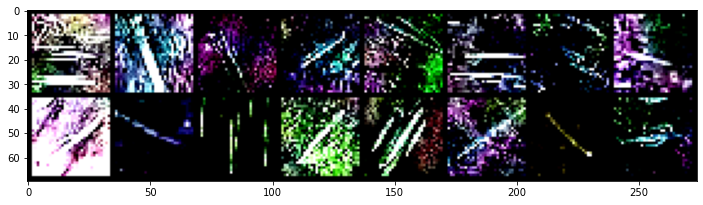

In [49]:
test_dataloader = create_test_dataloader(flip_transform, DATA_FOLDER, BATCH_SIZE, SEED)

show_sample_images(test_dataloader)

# References
* López-Jiménez, Efren; Vasquez-Gomez, Juan Irving; Sanchez-Acevedo, Miguel Angel; Herrera-Lozada, Juan Carlos; Uriarte-Arcia, Abril Valeria (2019); “Columnar Cactus Recognition in Aerial Images using a Deep Learning Approach”. Ecological Informatics. 52. 131-138.
* Willaert, J. (2021, September 24). How to calculate the mean and standard deviation - normalizing datasets in Pytorch. Medium. Retrieved March 23, 2022, from https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c 